# Counting corners in polygons

In this optional exercise you will: 

* Train a CNN to count corners in polygons

## The data

The images are almost black and white images of polygons, from triangles up to polygons with 10 corners.
The task is simply to be able to predict the number of corners given an input image. The size of the 
images are 100x100. There is a training dataset of 5000 images and a testset of also 5000 images. There is also
a dataset where training data only contain odd number of corners and testdata only even number of corners.

## The exercises
See cell # below.


### CellName: Init (#1)
### CellType: Needed
### Cell instruction: Initializing the libraries
In the cell below, we import all the libraries that are needed for this exercises. There is one configuration parameter that you can change in this cell

* Inline or "pop out" plots.

See comments in the cell for more information. Run the cell by entering into the cell and press "CTRL Enter".


In [2]:
# These two lines is just to avoid some warnings, coming from the fact that we are running
# tensorflow 1.14 and not the latest version.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import tensorflow as tf
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda, concatenate
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, RNN

from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras import backend as K

from sklearn.metrics import *

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# To have the plots inside the notebook "inlin" should be True. 
# If "inlin" = False, then plots will pop out of the notebook
inlin = True # True/False
if inlin:
    %matplotlib inline
else:
    %matplotlib

import matplotlib
import matplotlib.pyplot as plt


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11567575051210126702
]


### CellName: Data (#2)
### CellType: Needed
### Cell instruction: Function for loading the polygons

Run the cell by entering into the cell and press "CTRL Enter".

In [3]:
def loadImages(folder,trgFile,n):
    import imageio
    def load_pics(folder,n):
        imgs = []
        for i in range(n):
            img = imageio.imread(folder+"img_{:05}.png".format(i+1))
            ch = img[:,:,0]
            imgs.append(ch)
        return np.array(imgs)

    def load_labels(fn):
        return np.loadtxt(fn, usecols=0)

    pic = load_pics(folder+"/", n)
    ndata, width, height = pic.shape

    inp = (pic/np.float32(255)).reshape(n, width, height, 1)
    trg = load_labels(trgFile)
    trg = trg[0:n]

    return inp, trg, width, height

def loadDataAll(nTrn, nTst):
    # Load data
    (trnInp, trnTrg, imgW, imgH) = loadImages("polyAll-trn", "polyAll-trn_trg.csv", nTrn)
    (tstInp, tstTrg, imgW, imgH) = loadImages("polyAll-tst", "polyAll-tst_trg.csv", nTst)

    if K.image_data_format() == 'channels_first':
        trnInp = trnInp.reshape(trnInp.shape[0], 1, imgH, imgW)
        tstInp = tstInp.reshape(tstInp.shape[0], 1, imgH, imgW)
        input_shape = (1, imgH, imgW)
    else:
        trnInp = trnInp.reshape(trnInp.shape[0], imgH, imgW, 1)
        tstInp = tstInp.reshape(tstInp.shape[0], imgH, imgW, 1)
        input_shape = (imgH, imgW, 1)

    print('trnInp shape:', trnInp.shape)
    print('tstInp shape:', tstInp.shape)

    return trnInp, trnTrg, tstInp, tstTrg, input_shape

def loadDataOddEven(nTrn, nTst):
    # Load data
    (trnInp, trnTrg, imgW, imgH) = loadImages("polyOdd-trn", "polyOdd-trn_trg.csv", nTrn)
    (tstInp, tstTrg, imgW, imgH) = loadImages("polyEven-tst", "polyEven-tst_trg.csv", nTst)

    if K.image_data_format() == 'channels_first':
        trnInp = trnInp.reshape(trnInp.shape[0], 1, imgH, imgW)
        tstInp = tstInp.reshape(tstInp.shape[0], 1, imgH, imgW)
        input_shape = (1, imgH, imgW)
    else:
        trnInp = trnInp.reshape(trnInp.shape[0], imgH, imgW, 1)
        tstInp = tstInp.reshape(tstInp.shape[0], imgH, imgW, 1)
        input_shape = (imgH, imgW, 1)

    print('trnInp shape:', trnInp.shape)
    print('tstInp shape:', tstInp.shape)

    return trnInp, trnTrg, tstInp, tstTrg, input_shape


### CellName: PlotImg (#3)
### CellType: Information
### Cell instruction: Show some of the images

Here we look at the first ten pictures in the training set, and their respective targets. 

Run the cell by entering into the cell and press "CTRL Enter".

trnInp shape: (10, 100, 100, 1)
tstInp shape: (10, 100, 100, 1)


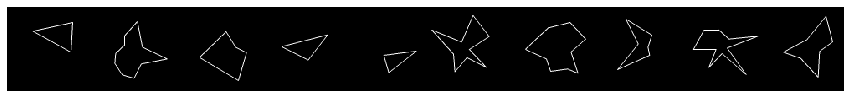

Targets:
[ 3. 10.  5.  3.  3.  9.  9.  6. 10.  7.]


In [4]:
trnInp, trnTrg, tstInp, tstTrg, input_shape = loadDataAll(10,10)
#trnInp, trnTrg, tstInp, tstTrg, input_shape = loadDataOddEven(10,10)

plt.figure(1, figsize=(15,10))
plt.imshow(trnInp[:10,:,:].swapaxes(0,1).reshape(input_shape[1],10*input_shape[1]),cmap="gray")
plt.axis("off")
plt.show()

print("Targets:")
print(trnTrg[:10])


### CellName: Stats (#4)
### CellType: Needed
### Cell instruction: Plot a confusion matrix

Run the cell by entering into the cell and press "CTRL Enter".

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


### CellName: Ex1 (#5)
### CellType: Exercise
### Cell instruction: Instructions for question 1-2

## CNN for counting corners

#### Question 1
The question is simple! **Find a CNN model that can accurately counts the corners in the test data set.**
You have access to 5000 training images, but you may have to reduce that to be able to run it on your computer. In the
example code below I use 1000 training images.

**Hint 1** The cell below contains my simple model that is not so accurate. You can use the code as a starting point.
**Hint 2** How can we count corners? My suggestion is to solve this using a regression approach. The CNN will try
to predict the number of corners. So my output is a single linear node and I use MSE as a loss function. You can of
course also try to solve it using a classification approach, but then you will a problem, extrapolating to other
number of corners.
**Hint 3** The target data for the images are the number of corners. I rescale this by 10 before training.
**Hint 4** Cells #6 and #7 contains some code for visualizing the results of your model.

#### Question 2
There is a function "loadDataOddEven" that loads a training dataset with only odd number of corners and a test
dataset with only even number of corners. **Try to "solve" this problem with a CNN!**



In [31]:
from tensorflow.keras.utils import to_categorical

# Get the training data
(trnInp, trnTrg, tstInp, tstTrg, input_shape) = loadDataAll(1000,5000)
print(set(trnTrg.ravel()))
trnTrg /= 10;
tstTrg /= 10;
#trnTrg = to_categorical(trnTrg)
#tstTrg = to_categorical(tstTrg)

print("Data loaded.")

trnInp shape: (1000, 100, 100, 1)
tstInp shape: (5000, 100, 100, 1)
{3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
Data loaded.


In [ ]:
from tensorflow.keras.layers import Input, Concatenate, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
import math

batch_size = 16
num_output = 1
epochs = 20

inputs = Input(input_shape)

# Convolutional base 1
x = Conv2D(16, (3, 3), padding="same", activation="relu")(inputs)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding="same", activation="relu")(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding="same", activation="relu")(x)
in_1 = GlobalAveragePooling2D()(x)

# Convolutional base 2
x = Conv2D(16, (5, 5), padding="same", activation="relu")(inputs)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(16, (5, 5), padding="same", activation="relu")(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(16, (5, 5), padding="same", activation="relu")(x)
in_2 = GlobalAveragePooling2D()(x)

# Convolutional base 3
x = Conv2D(8, (7, 7), padding="same", activation="relu")(inputs)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(8, (7, 7), padding="same", activation="relu")(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(8, (7, 7), padding="same", activation="relu")(x)
in_3 = GlobalAveragePooling2D()(x)

# Convolutional base 4
x = Conv2D(8, (9, 9), padding="same", activation="relu")(inputs)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(8, (9, 9), padding="same", activation="relu")(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(8, (9, 9), padding="same", activation="relu")(x)
in_4 = GlobalAveragePooling2D()(x)

outputs = Concatenate()([in_1, in_2, in_3, in_4])

conv_base = Model(inputs=inputs, outputs=outputs)



model = Sequential()

model.add(conv_base)

# The dense layers
#model.add(Flatten()) # Not needed if using GlobalAveragePooling
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(num_output, activation='linear'))
    
model.compile(loss='mean_squared_error',
              #optimizer=Adam(lr=0.0001),
              optimizer=RMSprop(),
              metrics=['mae'])
model.summary()
print("Model created.")

estimator = model.fit(trnInp, trnTrg,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(tstInp, tstTrg))

trnSc = model.evaluate(trnInp, trnTrg, verbose=0)
tstSc = model.evaluate(tstInp, tstTrg, verbose=0)
print('Trn loss:', trnSc[0])
print('Tst loss:', tstSc[0])

# Plot the learning curves
plt.figure()

plt.plot(estimator.history['loss'], label='Training')
plt.plot(estimator.history['val_loss'], label='Validation')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
plt.show()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_41 (Model)             (None, 48)                35776     
_________________________________________________________________
dense_80 (Dense)             (None, 10)                490       
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 11        
Total params: 36,277
Trainable params: 36,277
Non-trainable params: 0
_________________________________________________________________
Model created.
Train on 1000 samples, validate on 5000 samples
Epoch 1/20
1000/1000 [==============================] - 276s 276ms/sample - loss: 0.0627 - mean_absolute_error: 0.1926 - val_loss: 0.0270 - val_mean_absolute_error: 0.1373
Epoch 2/20
1000/1000 [===

### CellName: Scatterplot (#6)
### CellType: Exercise
### Cell instruction: Make a scatter plot

This cell just makes two scatter plots between the predicted output and the target output, for both
training and test data.

In [ ]:
# Scatter plots of predicted and true values
trnPred = model.predict(trnInp)*10
tstPred = model.predict(tstInp)*10
trnTr = trnTrg*10
tstTr = tstTrg*10

plt.figure()
plt.plot(trnPred[:], trnTr[:], 'g.', label='Predict vs True (Training)')
plt.legend()

plt.figure()
plt.plot(tstPred[:], tstTr[:], 'g.', label='Predict vs True (Test)')
plt.legend()

plt.show()


### CellName: Confusion (#7)
### CellType: Exercise
### Cell instruction: Plot confusion matrix

This cell just plots the confusion matrices for both training and testdata. In order to make a "prediction" of the number of corners, the output from the CNN model is rounded to nearest integer.

In [ ]:
from sklearn.metrics import confusion_matrix

# Scatter plots of predicted and true values
trnPred = model.predict(trnInp)*10
tstPred = model.predict(tstInp)*10
trnTr = trnTrg*10
tstTr = tstTrg*10

nTrn = trnInp.shape[0]
nTst = tstInp.shape[0]

trnClPred = np.rint(trnPred).reshape(nTrn)
trnClPred = trnClPred.astype(int)
trnClTrg = np.rint(trnTr).astype(int)

tstClPred = np.rint(tstPred).reshape(nTst)
tstClPred = tstClPred.astype(int)
tstClTrg = np.rint(tstTr).astype(int)

minTrn = min(min(trnClTrg), min(trnClPred))
maxTrn = max(max(trnClTrg), max(trnClPred))
trgName = [];
for x in range(minTrn, maxTrn+1):
    trgName.append(str(x))

minTst = min(min(tstClTrg), min(tstClPred))
maxTst = max(max(tstClTrg), max(tstClPred))
tstName = [];
for x in range(minTst, maxTst+1):
    tstName.append(str(x))
    
confuTrn = confusion_matrix(trnClTrg, trnClPred)
confuTst = confusion_matrix(tstClTrg, tstClPred)

plot_confusion_matrix(cm           = confuTrn, 
                      normalize    = False,
                      target_names = trgName,
                      title        = "Confusion Matrix: Training")

plot_confusion_matrix(cm           = confuTst, 
                      normalize    = False,
                      target_names = tstName,
                      title        = "Confusion Matrix: Test")


In [63]:
# Accuracy 0.2376

In [ ]:
# I presume that, all the different types of corners require different sizes of kernels for extraction. 
# Therefore, I parallelize many convolutional bases where the first layer has different kernel sizes.

# The fully-connected layer is kept as small as possible, because we don't need any non-linear mapping.
# Mainly because the target value is "invariant to transposes". We are only counting the number of corners.
# Therefore, the focus is to train a good convolution base layer.
from tensorflow.keras.utils import to_categorical

# Get the training data
(trnInp, trnTrg, tstInp, tstTrg, input_shape) = loadDataOddEven(1000,5000)
print(set(trnTrg.ravel()))
trnTrg /= 10;
tstTrg /= 10;
#trnTrg = to_categorical(trnTrg)
#tstTrg = to_categorical(tstTrg)

print("Data loaded.")

In [ ]:
batch_size = 8
num_output = 1
epochs = 40

inputs = Input(input_shape)

# Convolutional base 1
x = Conv2D(16, (3, 3), padding="same", activation="relu")(inputs)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(16, (3, 3), padding="same", activation="relu")(x)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(16, (3, 3), padding="same", activation="relu")(x)
in_1 = AveragePooling2D((4, 4))(x)

# Convolutional base 2
x = Conv2D(16, (5, 5), padding="same", activation="relu")(inputs)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(16, (5, 5), padding="same", activation="relu")(x)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(16, (5, 5), padding="same", activation="relu")(x)
in_2 = AveragePooling2D((4, 4))(x)

# Convolutional base 3
x = Conv2D(8, (7, 7), padding="same", activation="relu")(inputs)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(8, (7, 7), padding="same", activation="relu")(x)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(8, (7, 7), padding="same", activation="relu")(x)
in_3 = AveragePooling2D((4, 4))(x)

# Convolutional base 4
x = Conv2D(8, (9, 9), padding="same", activation="relu")(inputs)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(8, (9, 9), padding="same", activation="relu")(x)
x = AveragePooling2D((4, 4))(x)
x = Conv2D(8, (9, 9), padding="same", activation="relu")(x)
in_4 = AveragePooling2D((4, 4))(x)

outputs = Concatenate()([in_1, in_2, in_3, in_4])

conv_base = Model(inputs=inputs, outputs=outputs)



model = Sequential()

model.add(conv_base)

# The dense layers
model.add(Flatten())
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(num_output, activation='linear'))
    
model.compile(loss='mean_squared_error',
              #optimizer=Adam(lr=0.0001),
              optimizer=RMSprop(),
              metrics=['mae'])
model.summary()
print("Model created.")

estimator = model.fit(trnInp, trnTrg,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(tstInp, tstTrg))

trnSc = model.evaluate(trnInp, trnTrg, verbose=0)
tstSc = model.evaluate(tstInp, tstTrg, verbose=0)
print('Trn loss:', trnSc[0])
print('Tst loss:', tstSc[0])

# Plot the learning curves
plt.figure()
plt.plot(estimator.history['loss'], label='Training')
plt.plot(estimator.history['val_loss'], label='Validation')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
plt.show()